# ProcessGrid

This notebook creates useful GIS shapefiles based on the 2D mesh that defines the SSM grid. In particular, it uses an input shapefile that defines a region of interest for analysis to create shapefiles that contain only the grid nodes within that region. Node IDs from the 2D mesh are preserved.

## Parameters

Input Files:

 * `ssm_full_grid_file`: The 2DM file that defines the model grid
 * `ecology_masked_cells_shp`: An ESRI shapefile exported from the geodatabase produced by WA Ecology that contains the nodes that must be masked in output analysis. The original geodatabase is available [here](https://fortress.wa.gov/ecy/ezshare/EAP/SalishSea/SalishSeaModelBoundingScenarios.html).
 * `ssm_domain_shapefile`: A custom ESRI shapefile that uses one or more polygons to define a region of interest for analysis.

Output Files:

 * `ssm_full_grid_shp`: A shapefile of all the model grid points.
 * `ssm_full_union_shp`: A shapefile of the entire model domain in a single polygon. This is used in some of the mapping notebooks to draw coastal boundaries and illustrate where the analysis region is missing areas.
 * `domain_out_shp`: A shapefile of the node points inside the region of interest.
 * `filled_domain_out_shp`: A shapefile of the node polygons (Ecology calls these TCEs: tracer control elements) inside the region of interest.
 * `node_mask_out_txt`: A textfile containing node IDs within the region of interest that need to be masked from analysis due to incorrect depth or receiving direct discharge. The file contains one node ID per line.

Other Configuration Parameters:

 * `crs`: The Coordinate Reference System (map projection) that the 2DM model grid uses (UTM zone 10)
 * `PARALLEL`: One cell uses multithreading by default to greatly speed up processing, depending on the hardware. Comment this out or set to False to run this code single-threaded, mainly for debugging or validation.

In [1]:
ssm_full_grid_file = "SSM_Grid/ssm_grid.2dm"

ecology_masked_cells_shp = "gis/ecology masked cells.shp"
ssm_domain_shapefile = "gis/ssm domain utm.shp"

ssm_full_grid_shp = "gis/ssm full grid.shp"
ssm_full_union_shp = "gis/ssm full union.shp"
domain_out_shp = "gis/ssm domain nodes.shp"
filled_domain_out_shp = "gis/ssm filled domain nodes.shp"
node_mask_out_txt = "gis/masked nodes.txt"

crs = "epsg:32610"
PARALLEL = True

import os
os.environ['USE_PYGEOS'] = '0'

from multiprocessing import Pool
from time import perf_counter
import py2dm
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import unary_union
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

from fvcom.grid import FvcomGrid

# Step 1: Process the Model Grid

Read the 2DM file into several GeoDataFrames using Py2DM. This will result in separate GeoDataFrames for the nodes and elements, as well as a Pandas DataFrame that keeps track of the element-node relationships (similar to a junction table in SQL databases).

In [2]:
grid = FvcomGrid.from_mesh(ssm_full_grid_file)
grid

FvcomGrid(ncoord=array([[4.132090e+05, 4.005810e+05, 3.904300e+05, ..., 4.981070e+05,
        4.990570e+05, 4.987110e+05],
       [4.916091e+06, 4.916573e+06, 4.916456e+06, ..., 5.233797e+06,
        5.233814e+06, 5.234142e+06],
       [1.027573e+02, 1.284466e+02, 1.284466e+02, ..., 4.000000e+00,
        4.000000e+00, 4.000000e+00]]), nv=array([[   88,    88,     2, ..., 16008, 16009, 16009],
       [    1,     2,    88, ..., 16011, 16011, 16012],
       [   89,     1,    90, ..., 16009, 16012, 16010]]), calc=True)

In [3]:
fullgrid = grid.nodes_gdf(crs=crs)
elements = grid.elements_gdf(crs=crs)
fullgrid.head()

,geometry,depth
1,POINT (413209.000 4916091.000),102.7573
2,POINT (400581.000 4916573.000),128.4466
3,POINT (390430.000 4916456.000),128.4466
4,POINT (380630.000 4918330.000),131.3113
5,POINT (375680.000 4925140.000),164.1391


These are the centroids of all the elements.

In [4]:
elements.head()

,geometry
1,"POLYGON Z ((405601.000 4923417.000 128.447, 41..."
2,"POLYGON Z ((405601.000 4923417.000 128.447, 40..."
3,"POLYGON Z ((400581.000 4916573.000 128.447, 40..."
4,"POLYGON Z ((390430.000 4916456.000 128.447, 40..."
5,"POLYGON Z ((390430.000 4916456.000 128.447, 39..."


Now that we have our DataFrames, use them to compute the shapes and representative areas around each node, as the polygon defined by the centroids of the surrounding elements.

Interior nodes are easy cases, where just the centroids of the surrounding elements and the midpoints to each neighbor node can be used to define a polygon. Exterior nodes, however, are not fully surrounded by elements and, in the SSM grid, can be part of exactly two elements which include an outer edge. The node itself is added in between both outer edge midpoints.

This work is computationally intensive so is performed in parallel by default.

In [5]:
filled_grid = grid.tces_gdf(crs=crs)
filled_grid.head()

,geometry
1,"POLYGON ((413506.500 4920787.500, 410871.333 4..."
2,"POLYGON ((395505.500 4916514.500, 400581.000 4..."
3,"POLYGON ((395505.500 4916514.500, 395667.333 4..."
4,"POLYGON ((385530.000 4917393.000, 385541.667 4..."
5,"POLYGON ((378155.000 4921735.000, 380625.000 4..."


# Step 2: Find the Domain of Interest

Load the shapefile that defines the domain of interest for results analysis. This file contains one or more region boundaries that contain the relevant portion of the model grid, created by hand in GIS software.

In [6]:
domain = gpd.read_file(ssm_domain_shapefile).to_crs(crs)
domain.head()

ERROR 1: PROJ: proj_create_from_database: Open of /home/benr/mambaforge/envs/ssm-analysis/share/proj failed


,FID,geometry
0,0,"POLYGON ((515248.761 5331015.833, 515248.761 5..."


Plot the grid overlaid on the domain of interest

<Axes: >

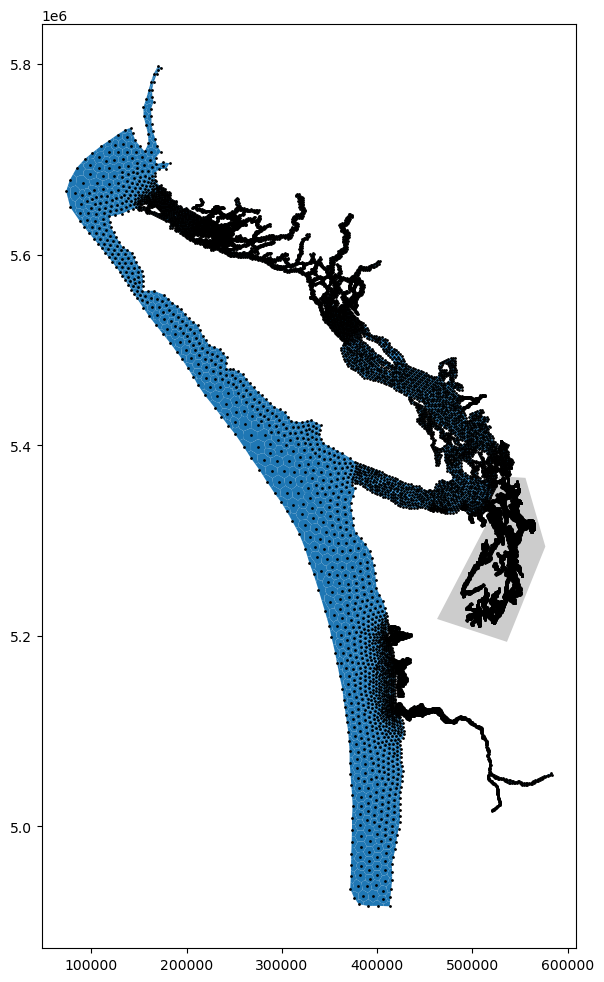

In [7]:
fig, ax = plt.subplots(figsize=(8,12))
filled_grid.plot(ax=ax)
domain.plot(ax=ax, color='gray', alpha=0.4)
fullgrid.plot(ax=ax, color='black', markersize=1)

Save a copy of the filled grid shapefile

In [8]:
filled_grid['depth'] = fullgrid['depth']
filled_grid.index.name = 'node_id'
filled_grid.head()

,geometry,depth
node_id,,
1,"POLYGON ((413506.500 4920787.500, 410871.333 4...",102.7573
2,"POLYGON ((395505.500 4916514.500, 400581.000 4...",128.4466
3,"POLYGON ((395505.500 4916514.500, 395667.333 4...",128.4466
4,"POLYGON ((385530.000 4917393.000, 385541.667 4...",131.3113
5,"POLYGON ((378155.000 4921735.000, 380625.000 4...",164.1391


In [9]:
filled_grid.to_file(ssm_full_grid_shp)

Make a union of all the nodes so we have a single polygon to use for plotting a background geography.

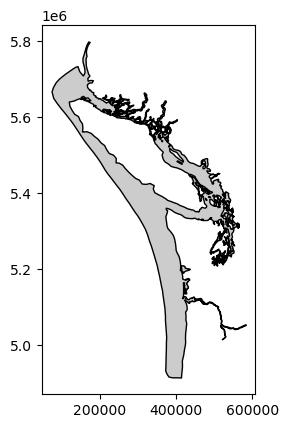

In [10]:
full_union = gpd.GeoDataFrame({
    'geometry': gpd.GeoSeries(unary_union(filled_grid['geometry']))
})
full_union.plot(facecolor='#ccc', edgecolor='k');

In [11]:
full_union.to_file(ssm_full_union_shp)

With the domain and the nodes defined, we can perform the spatial join to find just the nodes within the domain.

In [12]:
domain_nodes = gpd.tools.sjoin(fullgrid, domain)
domain_nodes.head()

,geometry,depth,index_right,FID
4369,POINT (515771.000 5333564.000),45.184,0,0
4370,POINT (515865.000 5334886.000),51.814,0,0
4371,POINT (516496.000 5336059.000),51.814,0,0
4372,POINT (517099.000 5337226.000),55.545,0,0
4373,POINT (518039.000 5338339.000),60.431,0,0


A bit of cleanup is required on this resulting GeoDataFrame, then save it.

In [13]:
del domain_nodes['index_right'], domain_nodes['FID']
domain_nodes.index.name = "node_id"
domain_nodes.to_file(domain_out_shp)

Create another version for the filled node areas.

In [14]:
filled_domain_nodes = filled_grid.loc[domain_nodes.index]
filled_domain_nodes['depth'] = domain_nodes['depth']
filled_domain_nodes.head()

,geometry,depth
node_id,,
4369,"POLYGON ((515281.500 5333310.500, 515468.000 5...",45.184
4370,"POLYGON ((515087.000 5334737.500, 515315.000 5...",51.814
4371,"POLYGON ((515719.500 5336024.000, 515768.000 5...",51.814
4372,"POLYGON ((516396.667 5336859.000, 516797.500 5...",55.545
4373,"POLYGON ((517117.667 5338020.667, 517569.000 5...",60.431


In [15]:
filled_domain_nodes.to_file(filled_domain_out_shp)

# Step 3: Build the Node Mask

Last thing to do is build a mask for intertidal cells.

In [16]:
masked = gpd.read_file(ecology_masked_cells_shp)
masked.set_index("tce", inplace=True)
masked.to_crs(crs, inplace=True)
masked.head()

,OBJECTID,Shape_Leng,Shape_Area,geometry
tce,,,,
1157,1.0,8527.096019,4.081405e+06,"POLYGON ((376237.770 5360753.200, 374772.385 5..."
1251,2.0,8383.995136,3.868014e+06,"POLYGON ((379220.000 5360010.000, 377728.885 5..."
1340,3.0,8305.817277,4.095675e+06,"POLYGON ((381920.580 5358753.800, 380570.290 5..."
1624,4.0,8388.514021,4.151215e+06,"POLYGON ((392213.310 5352636.200, 391004.665 5..."
1674,5.0,8326.828777,4.170734e+06,"POLYGON ((394680.740 5350902.400, 393447.025 5..."


In [17]:
masked.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

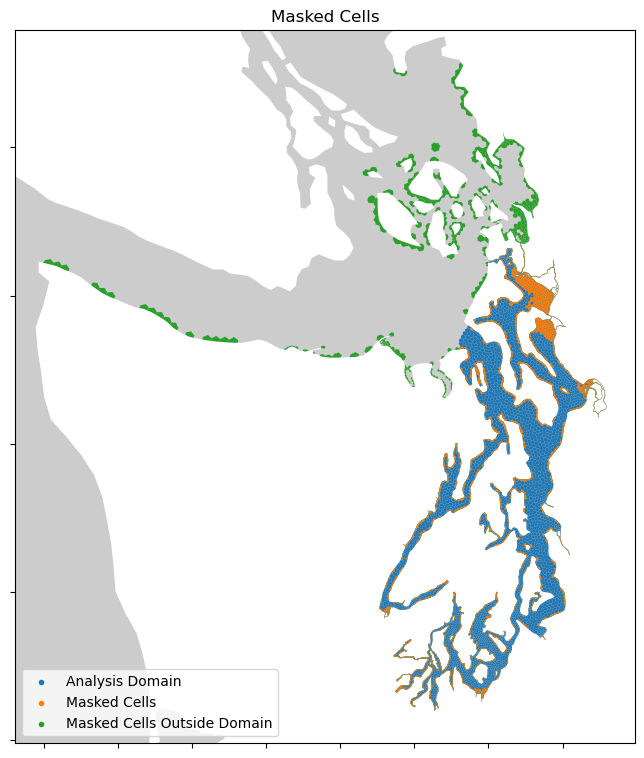

In [27]:
fig, ax = plt.subplots(figsize=(8,12))
masked.plot(facecolor='tab:green', ax=ax, zorder=2)
masked_from_nodes = filled_domain_nodes.loc[
    filled_domain_nodes.index.isin(masked.index)
]
p = masked_from_nodes.plot(facecolor='tab:orange', ax=ax, zorder=4)
# Save the axes boundaries so we can restore them after plotting the full model
# boundary
xmin, xmax, ymin, ymax = p.axis()
filled_domain_nodes.plot(facecolor='tab:blue', ax=ax, zorder=3)
full_union.plot(ax=ax, zorder=1, color='#ccc')
# Hack to create a legend
ax.scatter(-1, -1, marker='.', color='tab:blue', label='Analysis Domain')
ax.scatter(-1, -1, marker='.', color='tab:orange', label='Masked Cells')
ax.scatter(-1, -1, marker='.', color='tab:green', label='Masked Cells Outside Domain')
ax.set(title="Masked Cells", ybound=(ymin, ymax),
       xbound=(xmin, xmax), xticklabels=(), yticklabels=())
ax.legend(loc='lower left');

Now save the masked nodes as a simple text file, one per line so it's easy to modify.

In [22]:
np.savetxt(node_mask_out_txt, masked.index.to_numpy()[:,np.newaxis])